In this work autoencoder neural network architecture is applied for image compression. 

TODO

In [1]:
# imports

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from lossless_autoencoder import LosslessAutoencoder
from image_dataset import ImageDataset
from trainer import train
from utils import (
    plot_dataset, plot_augmentation, plot_learning_curve, plot_data_latent_decoded
)
from pca_visualization import pca_visualization

from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision.transforms import v2

In [2]:
np.random.seed(42)
torch.manual_seed(42);

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))
print(f"Train set size: {len(MNIST_train.targets)}")
MNIST_test = datasets.MNIST('./mnist', train=False, download=True, transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))
print(f"Test set size: {len(MNIST_test.targets)}")

X_train = MNIST_train.data / MNIST_train.data.max()
X_test = MNIST_test.data / MNIST_train.data.max()

Train set size: 60000
Test set size: 10000


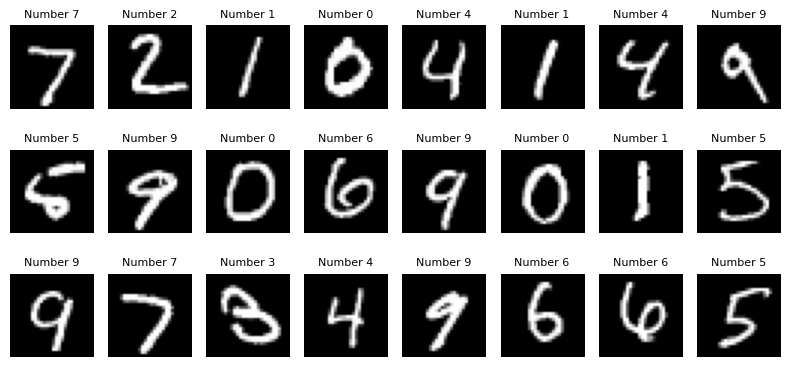

In [5]:
plot_dataset(MNIST_test)

## Autoencoder model

In [6]:
lossless_autoencoder = LosslessAutoencoder()
print(lossless_autoencoder)
print(summary(lossless_autoencoder))

LosslessAutoencoder(
  (encoder): LosslessEncoder(
    (encoder): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=784, bias=True)
      (2): PReLU(num_parameters=784)
      (3): Linear(in_features=784, out_features=784, bias=True)
      (4): PReLU(num_parameters=784)
    )
  )
  (decoder): LosslessDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=784, out_features=784, bias=True)
      (1): PReLU(num_parameters=784)
      (2): Linear(in_features=784, out_features=784, bias=True)
      (3): PReLU(num_parameters=784)
      (4): Unflatten(dim=-1, unflattened_size=(1, 28, 28))
      (5): Sigmoid()
    )
  )
)
Layer (type:depth-idx)                   Param #
LosslessAutoencoder                      --
├─LosslessEncoder: 1-1                   --
│    └─Sequential: 2-1                   --
│    │    └─Flatten: 3-1                 --
│    │    └─Linear: 3-2                  615,440
│    │    └─PReLU: 3-3                   

In [7]:
print(f'latent space size: {lossless_autoencoder.encode(X_train[0].reshape(1, 1, 28, 28)).shape[0]}')

latent space size: 784


In [8]:
lr = 1e-3
gamma = 0.98
batch_size = 100
num_epochs = 300

In [9]:
# data augmentation
train_transforms = v2.Compose([
    v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10, interpolation=v2.InterpolationMode.BILINEAR),
])

In [10]:
# augmentation before learning, dataset is increased aug_num times

aug_num = 10

old_num = X_train.shape[0]
X_augmented = torch.zeros((old_num * aug_num, 1, *X_train.shape[1:]))
X_augmented[:old_num, 0] = X_train
for i in range(1, aug_num):
    X_augmented[old_num*i:old_num*(i+1), 0] = train_transforms(X_train)

In [11]:
train_dataset = ImageDataset(X_augmented, transform=None)
test_dataser = ImageDataset(X_test.unsqueeze(1))

In [12]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataser,
    batch_size=batch_size,
    shuffle=False
)

In [13]:
optimizer = torch.optim.Adam(params=lossless_autoencoder.parameters(), lr=lr, weight_decay=1e-9)
loss_function = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

In [14]:
loss_logs = train(
    model=lossless_autoencoder,
    loss_function=loss_function,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_epochs=num_epochs,
    device=device
)

100%|██████████| 300/300 [3:33:24<00:00, 42.68s/it, train=5.43e-5, test=6.8e-5]   


In [26]:
#torch.save(lossless_autoencoder.state_dict(), 'lossless_fc_784_aug.pth')
#np.save('logs_lossless_fc_784_aug.npy', loss_logs)

# lossless_autoencoder = LosslessAutoencoder().to(device)
# lossless_autoencoder.load_state_dict(torch.load('lossless_fc_784_aug.pth'))
# loss_logs = np.load('logs_lossless_fc_784_aug.npy', allow_pickle=True)[()]

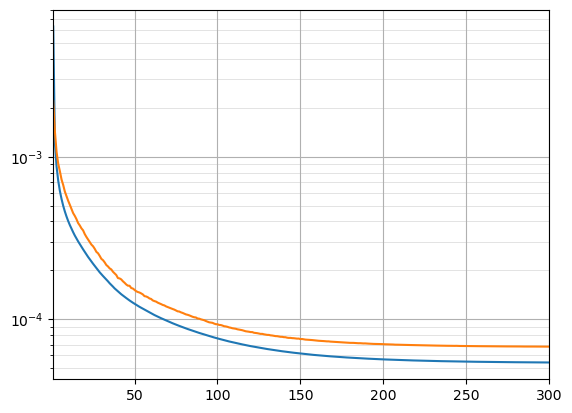

In [25]:
plot_learning_curve(loss_logs, num_epochs, semilogy=True)

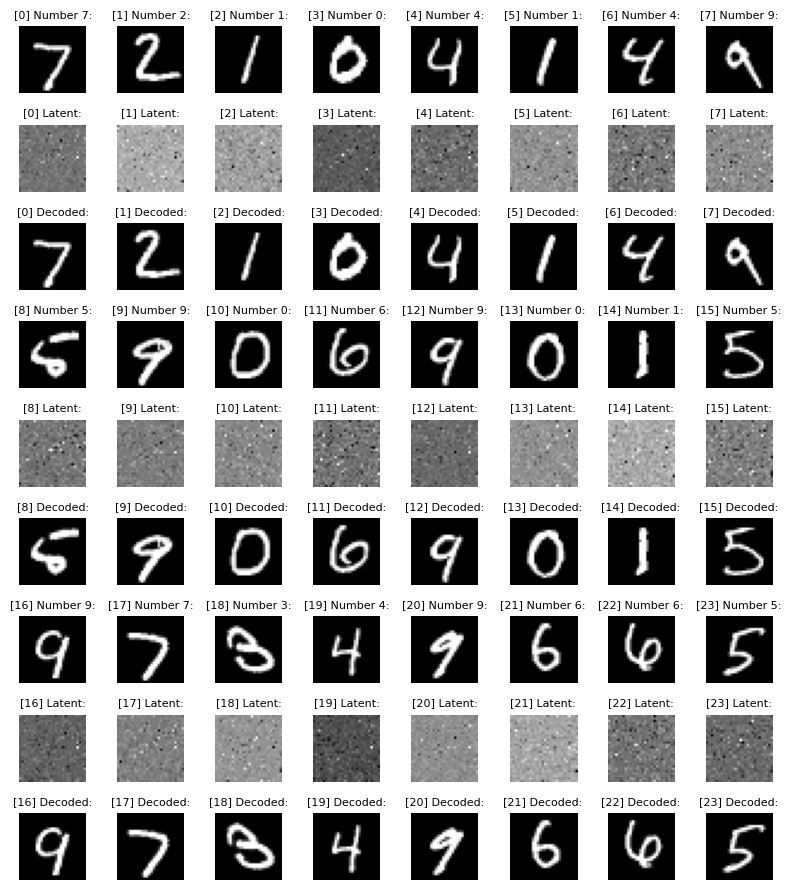

In [17]:
plot_data_latent_decoded(lossless_autoencoder, X_test, MNIST_test.targets, device)

In [18]:
X_train_latent = lossless_autoencoder.encode(X_train.to(device), flatten=False).squeeze().detach().cpu().numpy()
X_test_latent = lossless_autoencoder.encode(X_test.to(device), flatten=False).squeeze().detach().cpu().numpy()

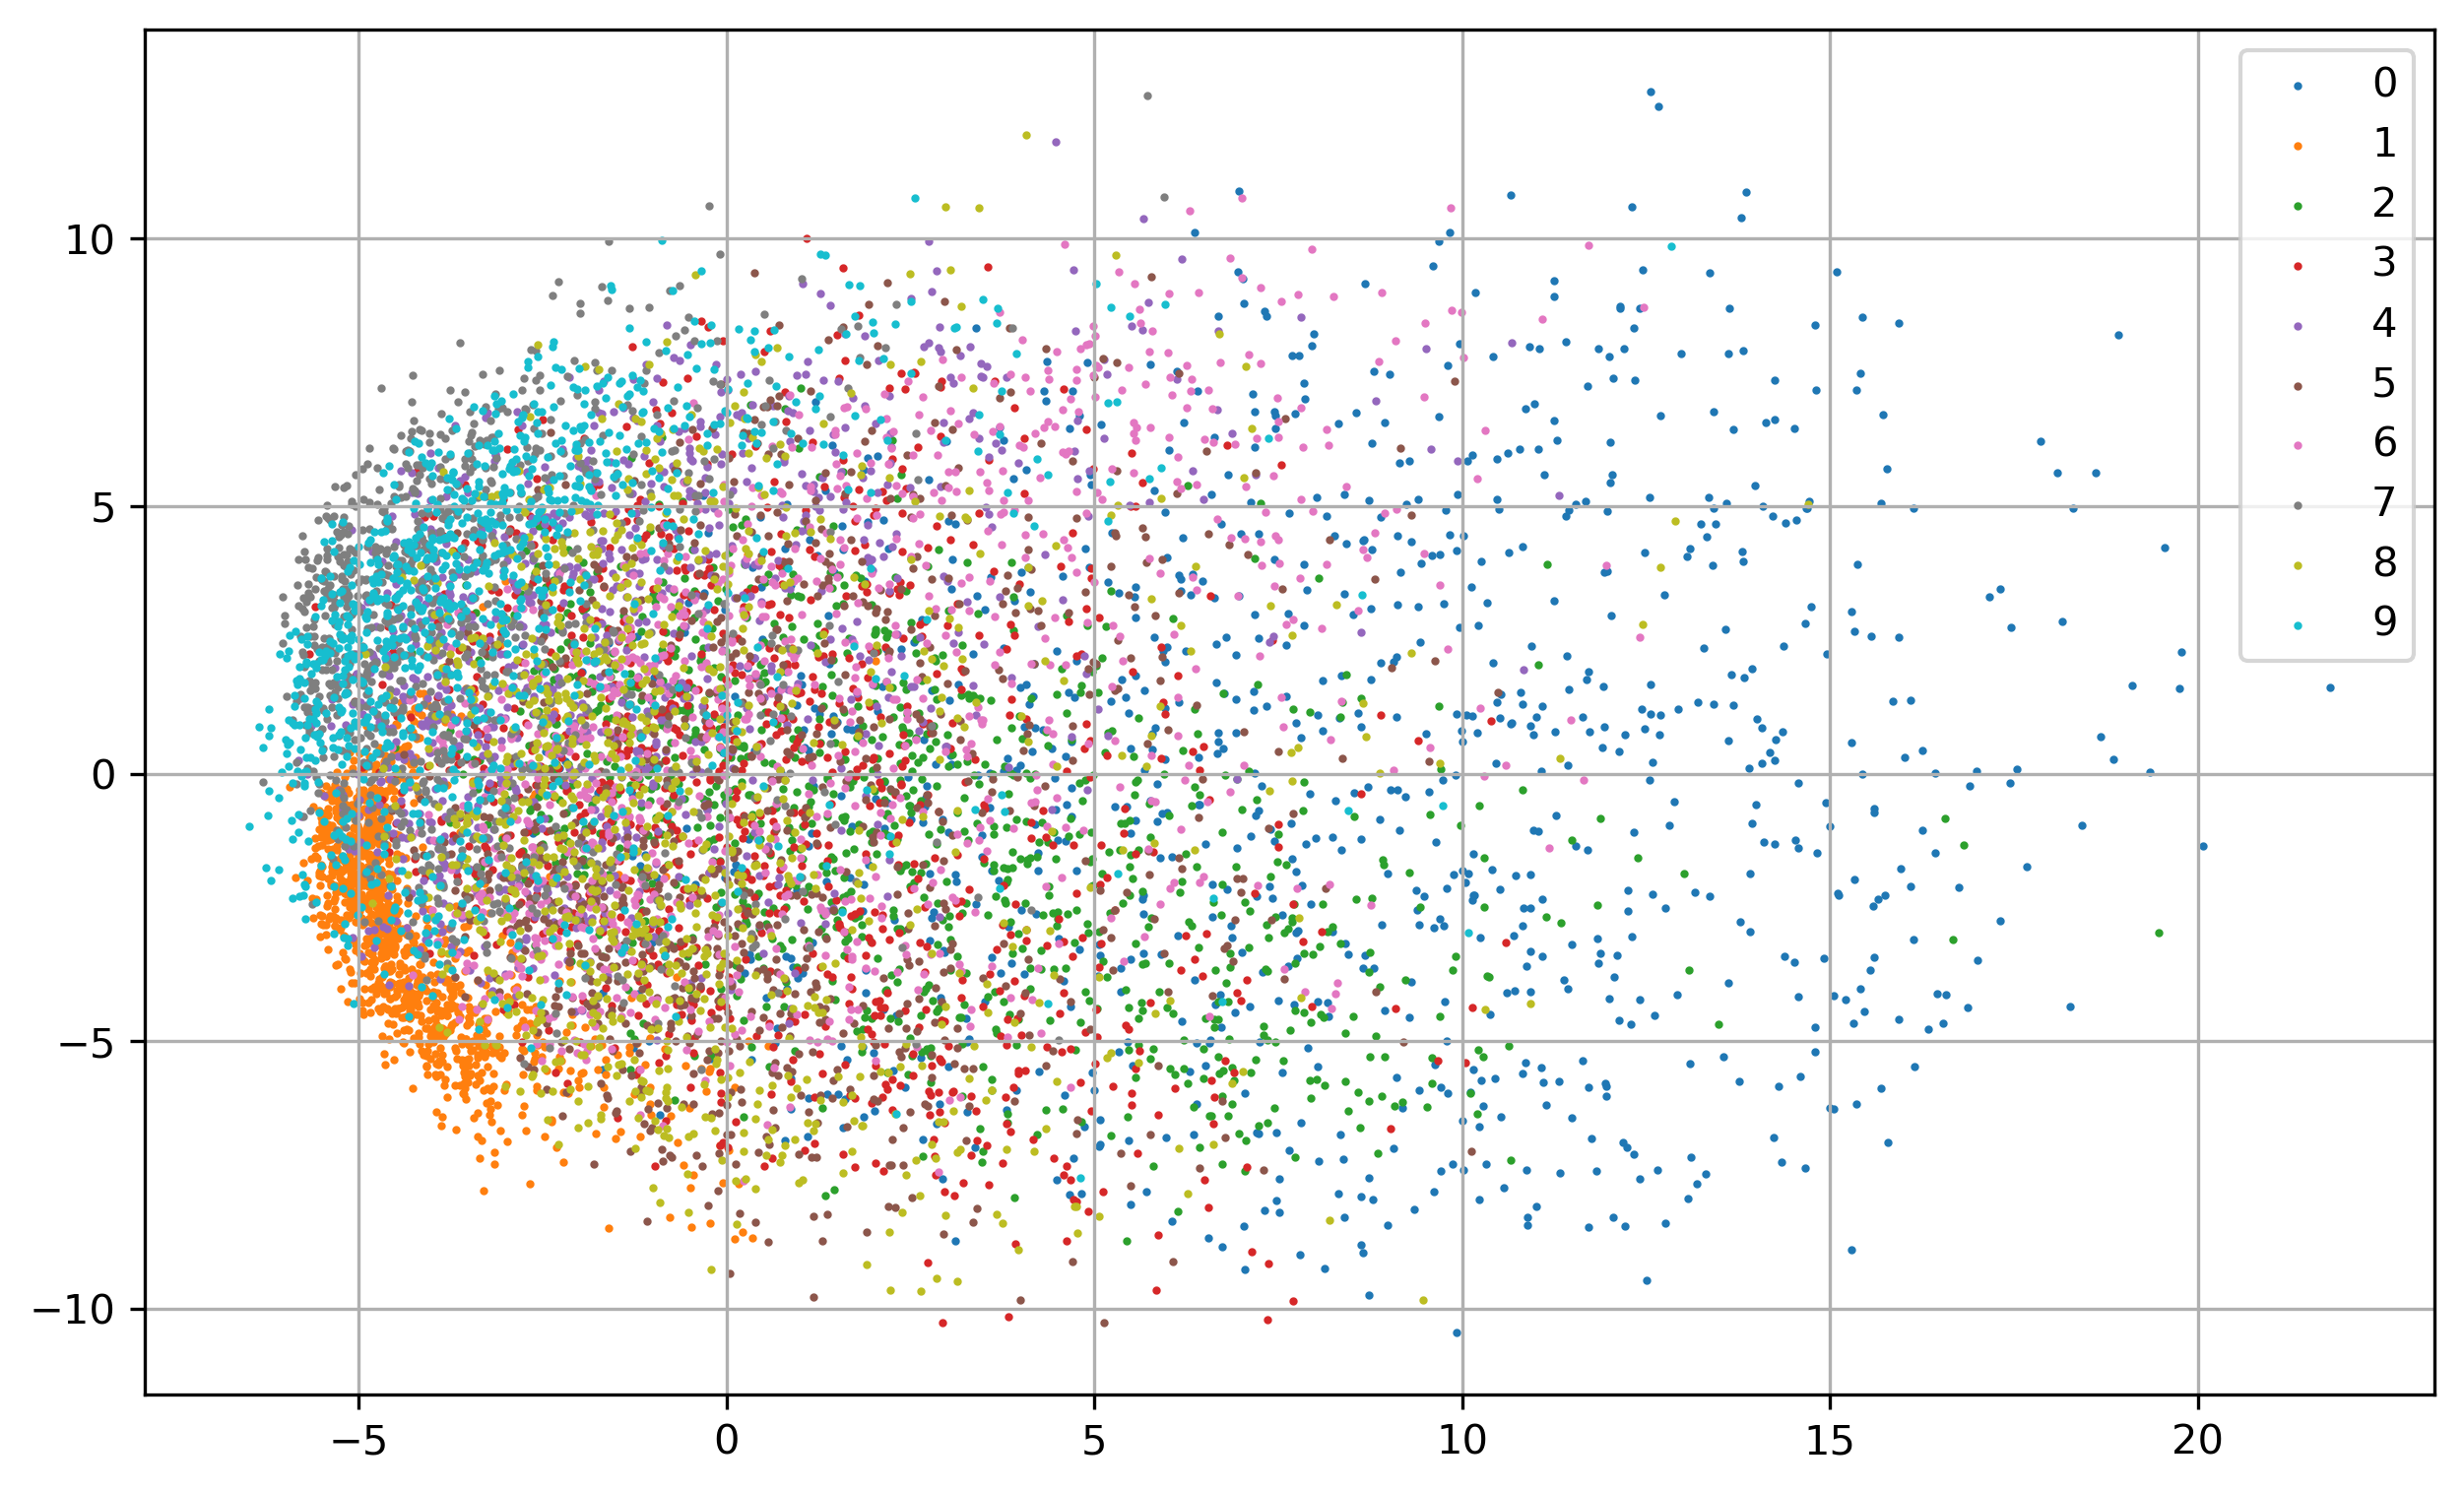

In [19]:
pca_visualization(X_train_latent, X_test_latent, MNIST_test.test_labels)